<a href="https://colab.research.google.com/github/NBK-code/Normalizing-Flows-and-VAEs/blob/main/Generalization_in_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import random
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization

In [5]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from zipfile import ZipFile
file_name = '2_images.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done!')

Done!


In [7]:
data_dir = pathlib.Path('/content/2_images')

In [8]:
print('The number of images:', len(list(data_dir.glob('*.png'))))

The number of images: 3000


In [9]:
images_dict = {
    '2_images': list(data_dir.glob('*'))
}

In [10]:
X_train = []

for category, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(64,64))
        X_train.append(resized_img)

In [11]:
len(X_train)

3000

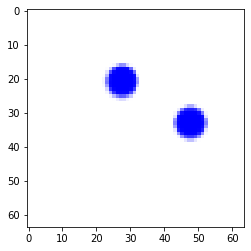

In [13]:
plt.imshow(X_train[11])

In [14]:
image_data = np.array(X_train)

In [15]:
image_data.shape

(3000, 64, 64, 3)

In [16]:
image_data[0].shape

(64, 64, 3)

In [17]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [18]:
gray_images = []

for image in image_data:
  gray_image = rgb2gray(image)
  gray_images.append(gray_image)

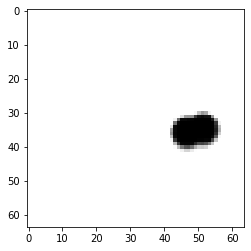

In [19]:
plt.imshow(gray_images[101], cmap='gray')

In [20]:
# Train and validation data split

train_images, val_images = train_test_split(image_data, test_size = 0.1)

In [21]:
print(train_images.shape)
print(val_images.shape)

(2700, 64, 64, 3)
(300, 64, 64, 3)


In [22]:
# Create train and validation datasets

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)

In [23]:
# Function to scale images

def scale_images(image):
  return tf.cast(image, tf.float32)/255.0

In [24]:
# Apply scale function to the datasets

train_dataset = train_dataset.map(scale_images)
val_dataset = val_dataset.map(scale_images)

In [25]:
# Function to return a tuple

def return_tuple(image):
  return image, image

In [26]:
# Apply tuple function to the datasets

train_dataset = train_dataset.map(return_tuple)
val_dataset = val_dataset.map(return_tuple)

In [27]:
# Shuffle the datasets

train_dataset = train_dataset.shuffle(1000)

In [28]:
# Batch the datasets

train_dataset = train_dataset.batch(20, drop_remainder=True)
val_dataset = val_dataset.batch(20, drop_remainder=True)

In [29]:
print(train_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(20, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 64, 64, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(20, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 64, 64, 3), dtype=tf.float32, name=None))


In [30]:
# Function to get prior

def get_prior(latent_dim):

  loc = tf.zeros(shape = (latent_dim,))
  prior = tfd.MultivariateNormalDiag(loc = loc)

  return prior

In [31]:
def get_encoder(latent_dim, prior_dist):
    
    encoder = Sequential([
        Conv2D(16, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME', 
               input_shape = (64, 64, 3)),
        BatchNormalization(),
        Conv2D(32, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME', 
               input_shape = (64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME'),
        BatchNormalization(),
        Conv2D(256, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim,
                                    activity_regularizer = tfpl.KLDivergenceRegularizer(prior_dist, 
                                                  weight = 1.0,
                                                  use_exact_kl = False, 
                                                  test_points_fn = lambda q: q.sample(3), 
                                                  test_points_reduce_axis = None))        
    ])
    
    return encoder

In [32]:
# Function to get decoder

def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(2304, activation = 'relu', input_shape = (latent_dim,)),
        Reshape((3,3,256)),
        UpSampling2D((2,2)),
        Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(32, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(32, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(3, (3,3), padding = 'SAME'),
        Flatten(),
        Dense(tfpl.IndependentBernoulli.params_size(event_shape = (64, 64, 3))),
        tfpl.IndependentBernoulli(event_shape = (64, 64, 3))
    ])
    
    return decoder

In [33]:
# Latent Dimension

latent_dim = 2

In [34]:
# Encoder summary

prior_dist = get_prior(latent_dim)

encoder = get_encoder(latent_dim, prior_dist)

encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        784       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        8224      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 64)         2

In [35]:
# Decoder summary

decoder = get_decoder(latent_dim)

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2304)              6912      
                                                                 
 reshape (Reshape)           (None, 3, 3, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 6, 6, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 64)          147520    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)       

In [36]:
# Create VAE model

VAE = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [37]:
# VAE summary

VAE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        784       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        8224      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          32832 

In [38]:
# Loss function

def reconstruction_loss(batch_of_images, decoding_dist):
    
    return tf.reduce_mean(-decoding_dist.log_prob(batch_of_images))

In [39]:
# Define optimizer and compile 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
VAE.compile(optimizer=optimizer, loss=reconstruction_loss)

In [82]:
# Train the VAE model

history = VAE.fit(train_dataset, validation_data = val_dataset, epochs=60, verbose = True)

Epoch 1/60
135/135 [==============================] - 12s 87ms/step - loss: 367.3692 - val_loss: 893.9797
Epoch 2/60
135/135 [==============================] - 12s 88ms/step - loss: 364.3318 - val_loss: 1261.9668
Epoch 3/60
135/135 [==============================] - 12s 88ms/step - loss: 372.3689 - val_loss: 2115.5757
Epoch 4/60
135/135 [==============================] - 12s 88ms/step - loss: 372.6219 - val_loss: 825.8702
Epoch 5/60
135/135 [==============================] - 12s 89ms/step - loss: 357.4337 - val_loss: 1794.1869
Epoch 6/60
135/135 [==============================] - 12s 88ms/step - loss: 366.4309 - val_loss: 957.8371
Epoch 7/60
135/135 [==============================] - 12s 88ms/step - loss: 363.7897 - val_loss: 1766.8738
Epoch 8/60
135/135 [==============================] - 12s 89ms/step - loss: 365.3524 - val_loss: 875.5721
Epoch 9/60
135/135 [==============================] - 12s 89ms/step - loss: 364.5256 - val_loss: 1850.9933
Epoch 10/60
135/135 [====================

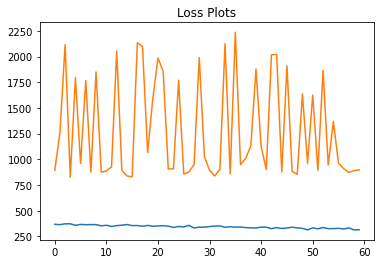

In [83]:
# Plot loss vs epochs

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss Plots")

plt.show()

In [84]:
# Randomly select 1000 images from our 3000 image dataset

seed_2 = random.sample(range(0,3000),1000)

In [85]:
# Obtain the embeddings for 1000 images

embeddings = encoder(tf.cast(image_data[seed_2] ,tf.float32)/255.0).mean()

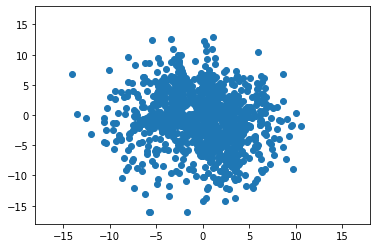

In [86]:
# Plot the embeddings

x = embeddings[...,0]
y = embeddings[...,1]
plt.scatter(x,y)
plt.xlim(-18,18)
plt.ylim(-18,18)
plt.show()

In [87]:
# Randomly select 4 images from the dataset

seed_3 = random.sample(range(0,1000),4)

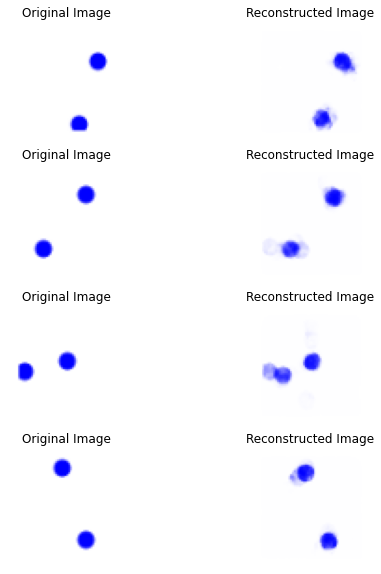

In [88]:
# Plot the original image and the reconstructed image

plt.figure(figsize=(8,10))
for i, v in enumerate(seed_3):
  plt.subplot(4,2,2*i+1)
  plt.imshow(image_data[v])
  plt.title('Original Image')
  plt.axis('off')

  im = tf.expand_dims(image_data[v],0)
  im = tf.cast(im, tf.float32)/255.
  r_im = tf.squeeze(VAE(im).mean())
  plt.subplot(4,2,2*i+2)
  plt.imshow(r_im)
  plt.title('Reconstructed Image')
  plt.axis('off')

In [109]:
# Sample embeddings randomly within a box of z_1 ~ (-15,15) and z_2 ~ (-15,15)

uniform_embedding = tfd.Uniform(low=-15.0, high=15.0)
random_embeddings_1 = tf.expand_dims(uniform_embedding.sample(6), axis = -1)
random_embeddings_2 = tf.expand_dims(uniform_embedding.sample(6), axis = -1)
random_embeddings = tf.concat([random_embeddings_1, random_embeddings_2], axis = -1)
print(random_embeddings.numpy())

[[ -5.8315945   6.860586 ]
 [  5.8927994 -10.346661 ]
 [  3.7677097   7.957035 ]
 [ -9.6124325  -2.329999 ]
 [-11.898312   14.875137 ]
 [  5.214283   -7.807435 ]]


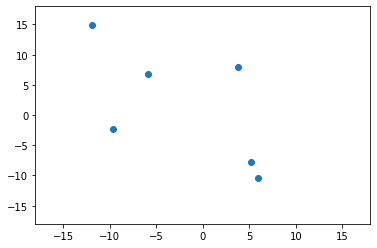

In [110]:
# Plot the embeddings

plt.scatter(random_embeddings_1, random_embeddings_2)
plt.xlim(-18,18)
plt.ylim(-18,18)
plt.show()

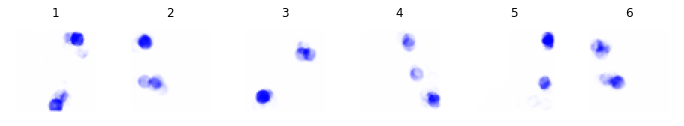

In [111]:
# Decode the embeddings and get the corresponding contour plots

new_images = decoder(random_embeddings).mean()

plt.figure(figsize=(12,8))
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.imshow(new_images[i])
  plt.axis('off')
  plt.title(i+1)

In [92]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-18, 18])
    ax1.set_ylim([-18, 18])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(True)
    ax1.axes.get_yaxis().set_visible(True)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(17 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

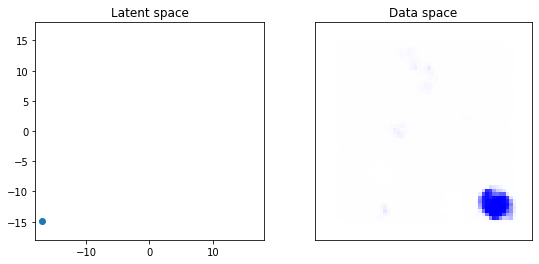

In [93]:
# Create the animation
latent_size = latent_dim
a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())